# CMRM Homework Assignment No. 1 (HW1)

In [1]:
import tqdm
from tqdm import tqdm
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# import other libraries


## Question 1

In [2]:
# Import dataset

import deeplake
ds = deeplake.load("hub://activeloop/gtzan-genre")


|

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/gtzan-genre



|

hub://activeloop/gtzan-genre loaded successfully.



In [3]:
Fs = 22050
n_samples = 29 * Fs # duration in samples 

# Define downsampling factors
sub_train = 10
sub_test = 50

train_range = list(range(0,1000,sub_train))
test_range = list(range(10,1000,sub_test))

# Extract classes
genre_names = ["pop", "metal", "classical", "rock", "bues", "jazz", "hipkop", "reggae", "disco", "country"]

genre_train = np.take(ds.genre, train_range, axis = 0)
genre_test = np.take(ds.genre, test_range, axis = 0)
print(np.shape(genre_train))
print(np.shape(genre_test))

# Extract training set
audio_train = []
for i in tqdm(train_range):
    audio_train.append(ds.audio[i, 0:n_samples, 0].numpy(aslist = True))
print(np.shape(audio_train))

# Extract test set
audio_test = []
for i in tqdm(test_range):
    audio_test.append(ds.audio[i,0:n_samples, 0].numpy(aslist = True))
print(np.shape(audio_test))

(100, 1)
(20, 1)


100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


(100, 639450)


100%|██████████| 20/20 [00:01<00:00, 16.08it/s]

(20, 639450)


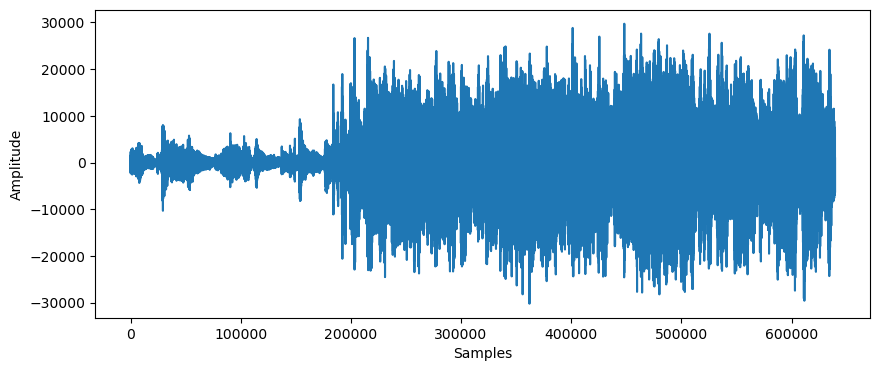

In [4]:
# Plot the first wav in the train set
plt.figure(figsize = (10, 4))
plt.plot(range(n_samples), audio_train[0])
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.show()

## Question 2

In [5]:
# Preprocessing
scaler = MinMaxScaler(feature_range = (-1,1))
pre_audio_train = scaler.fit_transform(audio_train)
pre_audio_test = scaler.fit_transform(audio_test)

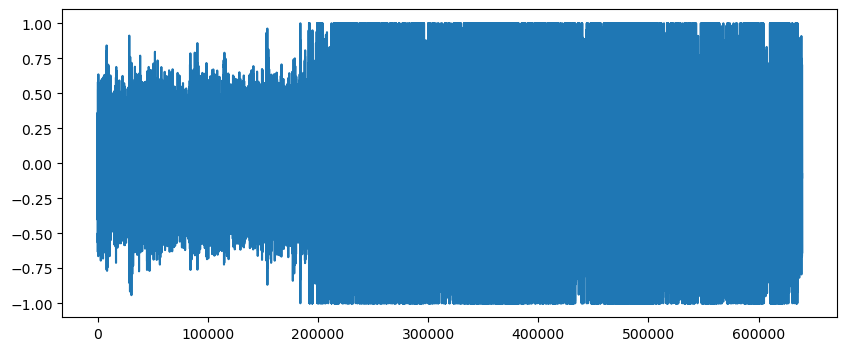

In [6]:
# Plot the first wav in the train set after preprocessing
plt.figure(figsize = (10,4))
plt.plot(range(n_samples), pre_audio_train[0])
plt.show()

In [7]:
# Compute local average
def compute_local_average(x, M):
    """Compute local average of signal

    Args:
        x: Signal
        M: Total length in samples of centric window  used for local average

    Returns:
        local_average: Local average signal
    """
    L = len(x)
    local_average = np.zeros(L)

    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])

    return local_average

# Compute the principal argument
def principal_argument(x):
    """Principal argument function 
    
    Args:
        x: value (or vector of values)
        
    Returns:
        y: Principal value of x
    """
    L = len(x)
    y = np.zeros(L)
    y = [((n + 0.5) % 1) - 0.5 for n in x]
    return y

# Compute the Phase-Based Novelty function
def compute_phase_novelty(x, Fs=1, N=1024, H=64, M=40, norm=True, plot=False):
    """Compute phase-based novelty function

    Args:
        x: Signal
        Fs: Sampling rate
        N: Window size
        H: Hop size
        M: Total length in samples of centric window  used for local average
        norm: Apply max norm (if norm==True)
        plot: plot novelty (if plot==True)

    Returns:
        nov: Phase-based novelty function
        Fs_nov: Novelty rate
    """
    
    # Compute the STFT
    X = librosa.stft(x,n_fft = N, hop_length = H, win_length = N, window = 'hann')
    
    # Compute the novelty rate
    Fs_nov = Fs/H
    
    # Extract the phase and use principal_argument
    phase = np.angle(X)/(2*np.pi)
    phase_diff = principal_argument(np.diff(phase, axis = 1))
    phase_diff2 = principal_argument(np.diff(phase_diff, axis = 1))
    # Accumulation over frequency axis
    nov = np.sum(np.abs(phase_diff2), axis = 0)
    nov = np.concatenate((nov, np.array([0,0])))
    
    # Local average subtraction and half-wave rectification
    if M > 0:
        local_average = compute_local_average(nov,M)
        nov = nov - local_average
        nov[nov<0] = 0
    
    # Normalization
    if norm: 
        max = np.max(nov)
        if max > 0:
            nov = nov/max
    
    # Plot
    if plot:
        feature_time_axis = np.arange(nov.shape[0])
        plt.figure(figsize=(10,4))
        plt.plot(feature_time_axis, nov)
    
    return nov, Fs_nov

(array([0.        , 0.        , 0.02730107, ..., 0.01009789, 0.        ,
        0.        ]),
 0.015625)

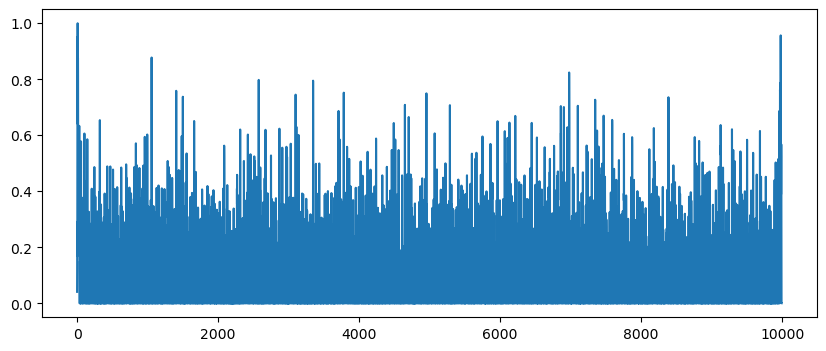

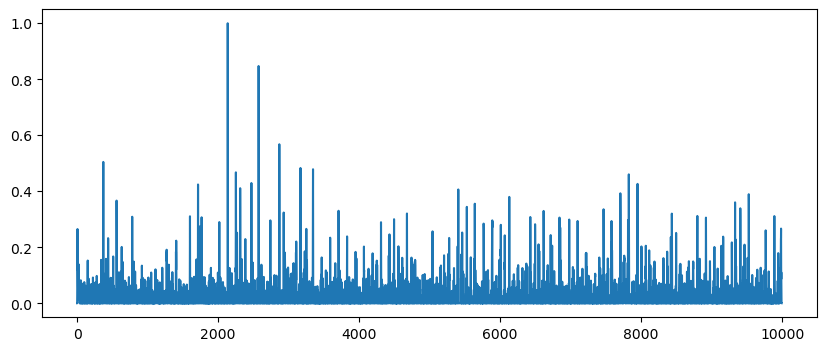

In [8]:
# Test the novelty function on the first wav in the train set

compute_phase_novelty(pre_audio_train[0], plot = True)
compute_phase_novelty(audio_train[0], plot = True)

## Question 3

In [9]:
def compute_feature_vector(x, Fs, N=2048, H=128):
    """Compute the feature vector 

    Args:
        x: Input signal
        Fs: Sampling rate
        N: Window length
        H: Hop size

    Returns:
        f_vector: Feature vector
    """
    
    # Compute rhythmic features
    phase_nov, Fs_nov = compute_phase_novelty(x, N = N, H = H)
    nov_std = np.std(phase_nov)
    nov_mean = np.mean(phase_nov)
    tempogram = librosa.feature.tempogram(y = x, hop_length = H, sr = Fs) # DA CONTROLLARE
    zcr = librosa.feature.zero_crossing_rate(y = x, hop_length = H)
    zcr_std = np.std(zcr)
    zcr_mean = np.mean(zcr)
    sf = librosa.onset.onset_strength( y = x, sr = Fs, S = None, lag = 1, max_size = 1, ref = None, detrend = False, center = True, aggregate = None, feature = None)
    sf_std = np.std(sf)
    sf_mean = np.mean(sf)
    tempo = librosa.feature.rhythm.tempo(y = x, hop_length = H)
    
    # Concatenate numpy arrays
    f_vector = np.concatenate((phase_nov,[nov_std, nov_mean], np.ravel(zcr),[zcr_std,zcr_mean], sf, [sf_std, sf_mean], tempo))
    
    
    return f_vector

In [10]:
# Compute feature vector for all the audio files inside the training set
N = 2048
H = 128

train_fvector = []
"""for i in range(len(pre_audio_train)):
    train_fvector.append(compute_feature_vector(pre_audio_train[i], Fs = Fs))
print(np.shape(train_fvector))
type(train_fvector)
for i in range(20):
    print(train_fvector[i])

print(len(pre_audio_train))"""

for i in tqdm(range(len(pre_audio_train)), desc = 'Train feauture vector loading'):
    train_fvector.append(compute_feature_vector(pre_audio_train[i], Fs = 22050))

print(np.shape(train_fvector))
print(type(train_fvector))    

test_fvector = []
for i in tqdm(range(len(pre_audio_test)), desc = 'Test feauture vector loading'):
    test_fvector.append(compute_feature_vector(pre_audio_test[i], Fs = 22050))

Train feauture vector loading: 100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


(100, 11248)
<class 'list'>


Test feauture vector loading: 100%|██████████| 20/20 [00:49<00:00,  2.50s/it]


In [11]:
# Check train_fvector and genre_train shapes
print(np.shape(train_fvector))

print(np.shape(test_fvector))


(100, 11248)
(20, 11248)


## Question 4

In [18]:
# Define model parameters
import sklearn
from sklearn import svm
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

if not os.path.exists('my_model/'):
    os.mkdir('my_model/')

def find_best_model(X_train, y_train):
    
    param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
                  'C': [0.001,0.01 ,0.1, 1, 10, 5],
                    }
    svm_model = svm.SVC()

    print(param_grid)
 
    grid_search = GridSearchCV(svm_model, param_grid, cv = 5, scoring = 'accuracy')
    print('gridSearch')
    grid_search.fit(X_train, y_train.reshape(-1))
    print('fit')

    best_params = grid_search.best_params_
    print(best_params)

    best_svm_model = svm.SVC(**best_params)
    print('creation of the model')
    best_svm_model.fit(X_train, y_train.reshape(-1))
    print('fitting best model')

    y_val_pred = best_svm_model.predict(X_train)
    print('prediction')
    val_accuracy = accuracy_score(y_train.reshape(-1), y_val_pred)
    print('END')

    return best_svm_model, best_params, val_accuracy

"""def find_best_cv(X, y, model, cv_values):
    best_cv = None
    best_score = float('-inf')

    for cv in cv_values:
        scores = cross_val_score(model, X, y, cv = cv)
        avg_score = np.mean(scores)

        if avg_score > best_score:
            best_score = avg_score
            best_cv = cv
    
    return best_cv, best_score"""

"""kernel = 'linear'
C = 1

# Train SVC
model = sklearn.svm.SVC(C = C, kernel = kernel)
model.fit(train_fvector, genre_train.reshape(-1))

model_save = f"my_model/svc_{kernel}_C_{C}_N_{N}_H_{H}.joblib"
joblib.dump(model, model_save)
"""


'kernel = \'linear\'\nC = 1\n\n# Train SVC\nmodel = sklearn.svm.SVC(C = C, kernel = kernel)\nmodel.fit(train_fvector, genre_train.reshape(-1))\n\nmodel_save = f"my_model/svc_{kernel}_C_{C}_N_{N}_H_{H}.joblib"\njoblib.dump(model, model_save)\n'

In [24]:
# Print the accuracy on the training set
""""y_train_prediction = model.predict(train_fvector)
accuracy = accuracy_score(genre_train.reshape(-1), y_train_prediction)
print(str(float(accuracy)*100)+'%')"""

best_svm_model, best_params, val_accuracy = find_best_model(train_fvector, genre_train)
print(best_params)
print(val_accuracy)
y_test_predict = best_svm_model.predict(test_fvector)
print(np.shape(y_test_predict))
print(accuracy_score(genre_test.reshape(-1), y_test_predict))



{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.001, 0.01, 0.1, 1, 10, 5]}
gridSearch
fit
{'C': 0.1, 'kernel': 'linear'}
creation of the model
fitting best model
prediction
END
{'C': 0.1, 'kernel': 'linear'}
1.0
(20,)
0.7


## Question 5

In [ ]:
# Classify the test set



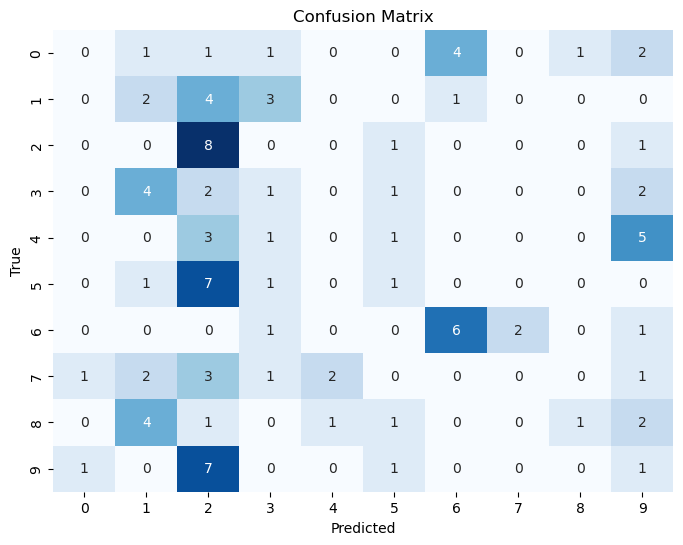

In [30]:
# Print the accuracy


# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import seaborn as sns

y_pred_cv = cross_val_predict(best_svm_model, train_fvector, genre_train.reshape(-1), cv=5)

conf_matrix = confusion_matrix(genre_train.reshape(-1), y_pred_cv)

plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, xticklabels = np.unique(genre_train.reshape(-1)), yticklabels = np.unique(genre_train.reshape(-1)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


